In [7]:
# ライブラリを読み込む
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import mlflow
import mlflow.sklearn

import os
import tempfile


In [8]:
# mlflow trackingサーバのURLを指定
mlflow.set_tracking_uri("http://mlflow:5000")

In [9]:
mlflow.set_experiment("tutorial") 

In [10]:
temp_dir = tempfile.TemporaryDirectory() 

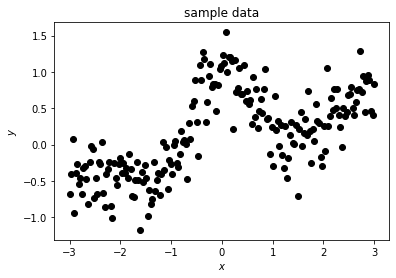

In [11]:
# サンプルデータ数
m = 200

# 乱数のシード値を指定することで，再現性を保つ 
np.random.seed(seed=2018)

# 「-3」から「3」の間で等間隔にm個のデータを作成
X = np.linspace(-3, 3, m)

# 後のグラフ描画用途に，10倍細かいグリッドを準備しておく
X_plot = np.linspace(-3, 3, m*10)

# 周期的なsin関数(第一項)に右上がり成分(第二項)と乱数(第三項)を加えたデータを作る
y = np.sinc(X) + 0.2 * X + 0.3 * np.random.randn(m)

# グラフ表示するため，各数列を1列の行列に変換
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)
X_plot = X_plot.reshape(-1,1)

# グラフを表示
plt.title("sample data")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(X, y, color="black")
plt.show()

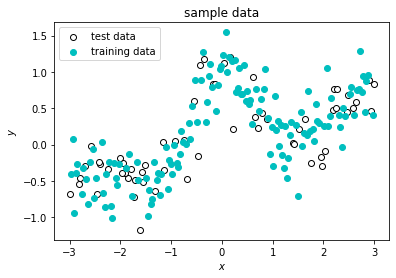

<Figure size 432x288 with 0 Axes>

In [12]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2019)

# 学習データとテストデータのグラフを表示
plt.scatter(X_test, y_test, label="test data", edgecolor='k',facecolor='w')
plt.scatter(X_train, y_train, label="training data", color='c')
plt.title("sample data")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

# 作成したグラフをファイルに保存
filename = os.path.join(temp_dir.name, "train_and_test_data.png")
plt.savefig(filename)

In [13]:
# 分割前のデータセット
np.savetxt(os.path.join(temp_dir.name, "dataset_X.csv"), X, delimiter=',')
np.savetxt(os.path.join(temp_dir.name, "dataset_y.csv"), y, delimiter=',')

# 学習データとテストデータに分割後のデータセット
np.savetxt(os.path.join(temp_dir.name, "X_train.csv"), X_train, delimiter=',')
np.savetxt(os.path.join(temp_dir.name, "y_train.csv"), y_train, delimiter=',')
np.savetxt(os.path.join(temp_dir.name, "X_test.csv"), X_test, delimiter=',')
np.savetxt(os.path.join(temp_dir.name, "y_test.csv"), y_test, delimiter=',')

In [14]:
# 予測結果のグラフを描画する関数を定義
def plot_result(model, X_train, y_train, score, filename=None):
    # 予測値の計算
    p = model.predict(np.sort(X_test))

    # グラフの描画
    plt.clf()
    plt.scatter(X_test, y_test, label="test data", edgecolor='k',facecolor='w')
    plt.scatter(X_train, y_train, label="Other training data", facecolor="r", marker='x')
    plt.scatter(X_train[model.support_], y_train[model.support_], label="Support vectors", color='c')

    plt.title("predicted results")
    plt.xlabel("$x$")
    plt.ylabel("$y$")

    x = np.reshape(np.arange(-3,3,0.01), (-1, 1))
    plt.plot(x, model.predict(x), label="model ($R^2=%1.3f$)" % (score), color='b')

    plt.legend()
    plt.show()
    # グラフの保存
    if filename is not None:
        plt.savefig(filename)

2021/06/03 02:33:12 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



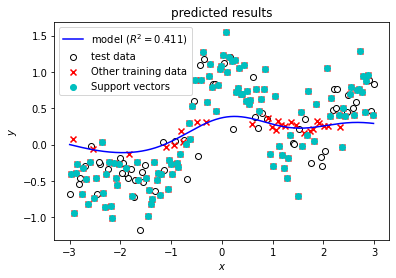

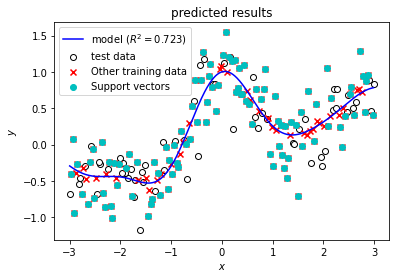

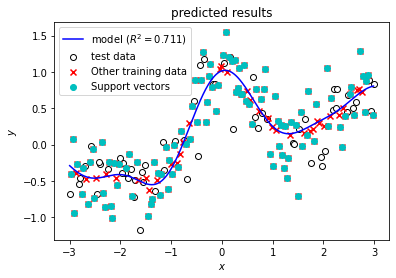

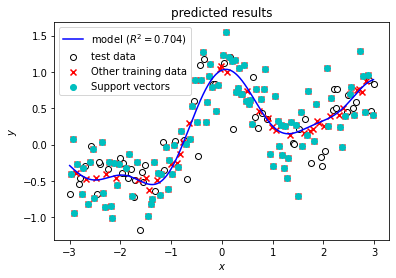

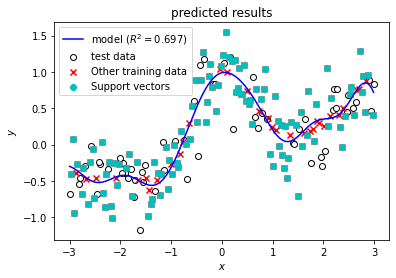

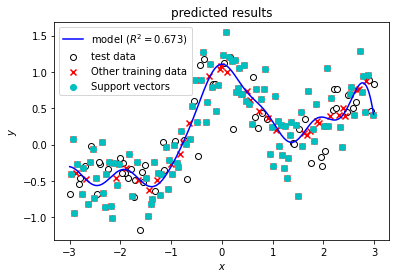

<Figure size 432x288 with 0 Axes>

In [15]:
for C in (0.01, 1, 5, 10, 100, 1000):
    # ここからの処理を一つのrunとしてmlflowに記録する
    with mlflow.start_run(run_name="Search C"):

        # モデルの学習を実行
        model = SVR(kernel='rbf', C=C, epsilon=0.1, gamma='auto').fit(X_train, np.ravel(y_train))

        # 保存しておいたデータセットをMLflowへ送信する
        mlflow.log_artifacts(temp_dir.name, artifact_path="dataset")

        # タグを指定
        mlflow.set_tag("algorism", "SVR")

        # ハイパーパラメータを記録する
        mlflow.log_param("C", C)

        # 精度指標を計算し，MLflowに送信する 
        score = model.score(X_test, y_test)
        mlflow.log_metric("R2 score", score)

        # モデルを記録したファイルをMLflowに送信する
        mlflow.sklearn.log_model(model, "model", serialization_format='cloudpickle')

        # 一時ディレクトリに予測結果のグラフを保存して，mlflowに送信する
        with tempfile.TemporaryDirectory()  as tmp:
            filename = os.path.join(tmp, "predict_results.png")
            plot_result(model, X_train, y_train, model.score(X_test, y_test), filename)
            mlflow.log_artifact(filename, artifact_path="results")